<a href="https://colab.research.google.com/github/farhan1503001/Deep-Learning-Rhyme-Projects/blob/main/Human_Image_Segmentation_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

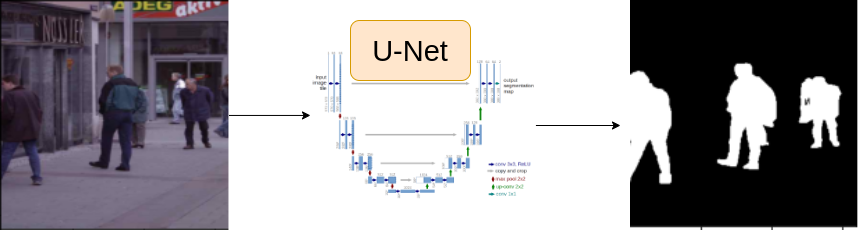

# Some Common Imports

In [42]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [43]:
#importing the necessary libraries
import torch
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import helper
from tqdm import tqdm # will help us to track the progress
from sklearn.model_selection import train_test_split#will help us to split train and test data.

# Task : 2 Setup Configurations

In [58]:
#Now we will define all the necessary constants for this project work
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE='cuda'
Learning_rate=0.003
IMAGE_SIZE=320
BATCH_SIZE=16
Encoder='timm-efficientnet-b0'
Weights='imagenet'

In [45]:
#Now reading from csv file
dataframe=pd.read_csv(CSV_FILE)
dataframe.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [46]:
#Now we will visualize a random image by reading it
index=dataframe.iloc[3]

image_path=index.images
mask_path=index.masks
#Now reading image
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
#Now reading mask
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

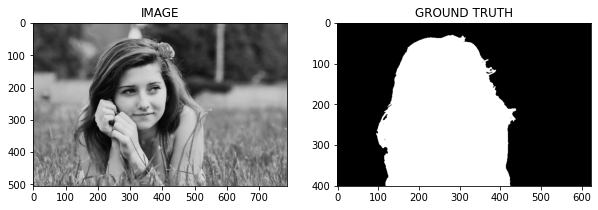

In [47]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image,cmap='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [48]:
#Now splitting train and test data frame
train_df,test_df=train_test_split(dataframe,test_size=0.20,random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [51]:
import albumentations as album 
#Now creating augmentation function for trainind data
def train_augment():
  #return album.
  return album.Compose(
      [
      album.Resize(IMAGE_SIZE,IMAGE_SIZE),
      album.HorizontalFlip(p=0.5),
      album.VerticalFlip(p=0.5)
      ]
  )
def valid_augment():
  return album.Compose(
      [
       album.Resize(IMAGE_SIZE,IMAGE_SIZE)
      ]
  )


# Task 4 : Create Custom Dataset 

In [52]:
#Now importing torch modules to create a custom dataset
from torch.utils.data.dataset import Dataset

In [53]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations
  def __len__(self):
    #Return the size of set
    return len(self.df)
  def __getitem__(self, index):
    row=self.df.iloc[index]
    image_path=row.images
    mask_path=row.masks

    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

    #adding extra dimensions
    mask=np.expand_dims(mask,axis=-1)

    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']

      #Now doing channel shaping for converting to tensor
      #(h,w,c) will become (c,h,w)
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)

      #Now we are converting image to tensor
    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)
    return image,mask

In [54]:
#Now finally creating our custom dataset
trainset=SegmentationDataset(train_df,train_augment())
validset=SegmentationDataset(test_df,valid_augment())

In [55]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


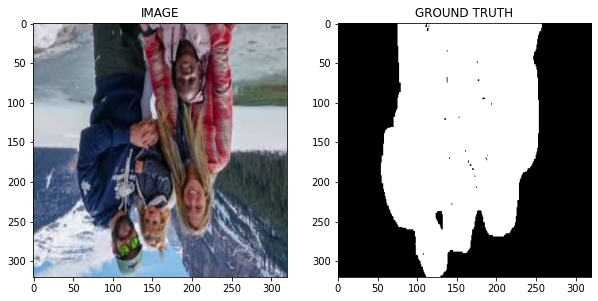

In [56]:
#now we want to visualize the image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
index=2
image,mask=trainset[index]      
ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap='gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap ='gray')

# Task 5 : Load dataset into batches

In [57]:
#Now we will divide the whole dataset in batches
from torch.utils.data.dataloader import DataLoader

In [59]:
train_dataloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader=DataLoader(validset,batch_size=BATCH_SIZE)

In [60]:
print(f"Number of Batches in Train Loader {len(train_dataloader)}")
print(f"Number of Batches in Test Loader {len(valid_dataloader)}")

Number of Batches in Train Loader 15
Number of Batches in Test Loader 4


In [61]:
#Now just seeing the first batch
for image,mask in train_dataloader:
  break
print(f"One batch Image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch Image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

# Task 7 : Create Train and Validation Function 

# Task 8 : Train Model

# Task 9 : Inference

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya